In [0]:
# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

# Importación de librerías

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
%matplotlib inline
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split    
from sklearn.metrics import precision_score, mean_squared_error, confusion_matrix, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

#Carga de la base de datos

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')
carpeta_raiz = 'gdrive/My Drive/Colab Notebooks/evaluacion-cdramirezh-master/'
diabetes = pd.read_csv(carpeta_raiz + 'datos/diabetes.csv')
diabetes.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [5]:
diabetes.shape

(442, 11)

# Análisis de variables para decidir cuáles son relevantes

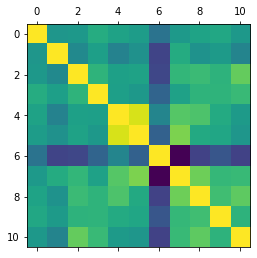

In [6]:
correlacion = diabetes.corr()
plt.matshow(correlacion)

Hay cuadros amarillos en el medio del gráfico, lo que nos indica que existen variables correlacionadas. Además, vemos cuadros muy cercanos al azul, lo que nos indica que existen variables correlacionadas inversamente. Se mirarán los valores numéricos para asegurarse.

In [7]:
correlacion

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


La correlación sugiere que:
  
*   entre *s2* y *s1* hay una relación (0.89) tal que solo sea necesario incluir una de las dos en los modelos, puedos que nos dan información similar.
*   *S3* parece estar inversamente correlacionada con todas las variables de manera leve, excepto con *s1* y *age*, con las cuales muestra poquísima correlación. Adicionalmente, *s3* tiene una alta correlación inversa con *s4*, por lo que una de las dos podría ser innecesaria
*   En relación a la salida Y, la variable que tiene menos relación con ella es *sex*, esto podría indicar que *sex* no es relevante para el modelo








Se hace una prueba de análisis de componentes principales para encontrar la variabilidad explicada y así salir de dudas sobre cuántas variables elegir para los modelos.

In [0]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [0]:
#normalizamos los datos
scaler=StandardScaler()
df = diabetes.drop(['Y'], axis=1) # quito la variable dependiente "Y"
scaler.fit(df) # calculo la media para poder hacer la transformacion
X_scaled=scaler.transform(df)# Ahora si, escalo los datos y los normalizo

In [0]:
#Instanciamos objeto PCA y aplicamos
pca=PCA(n_components=10) # Otra opción es instanciar pca sólo con dimensiones nuevas hasta obtener un mínimo "explicado" ej.: pca=PCA(.85)
pca.fit(X_scaled) # obtener los componentes principales
X_pca=pca.transform(X_scaled) # convertimos nuestros datos con las nuevas dimensiones de PCA

In [11]:
print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma7:',sum(expl[0:7]))
print('suma8:',sum(expl[0:8]))
#Vemos que con 8 componentes tenemos algo mas del 89% de varianza explicada. Suficiente para mí

shape of X_pca (442, 10)
[0.40242142 0.14923182 0.12059623 0.09554764 0.06621856 0.06027192
 0.05365605 0.04336832 0.00783199 0.00085605]
suma7: 0.9479436357350413
suma8: 0.9913119559917789


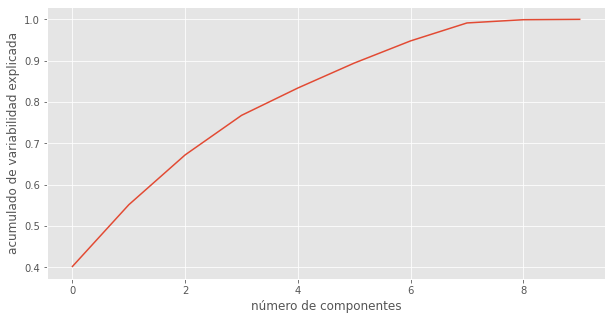

In [12]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('número de componentes')
plt.ylabel('acumulado de variabilidad explicada')
plt.show()

Sabiendo que existen 2 variables que explican solamente el 1%, se eligen 8 variables. Se descartan *s4* y *s2* por ser algunas de las variables antes señaladas como innecesarias o explicadas por otras variables

In [13]:
diabetes_var_slct = diabetes.drop(['s2', 's4'], axis = 1)
diabetes_var_slct.tail()

,age,sex,bmi,bp,s1,s3,s5,s6,Y
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.028674,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,-0.028674,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.024993,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,-0.028674,0.044528,-0.025930,220.0
441,-0.045472,-0.044642,-0.073030,-0.081414,0.083740,0.173816,-0.004220,0.003064,57.0


# Transformaciones

Se hace un resumen de los datos para mirar qué transformaciones se le podría hacer

In [14]:
diabetes_var_slct.describe()

,age,sex,bmi,bp,s1,s3,s5,s6,Y
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634599e-16,1.296411e-16,-8.042209e-16,1.281655e-16,-8.835316e-17,-4.575274e-16,-3.830854e-16,-3.411950e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.023071e-01,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.511716e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-6.584468e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.931150e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.811791e-01,1.335990e-01,1.356118e-01,346.000000


Se puede notar que las variables de entrada están bastante normalizadas, por ejemplo, el sexo está traducido a dato numérico y con solo dos valores, todos los datos de entrada están entre -1 y 1. Por lo que se decirde tomar la desición de realizar las transformaciones sobre la variables de salida ***Y***

In [0]:
lista_trans_Y = []
transformaciones = [('identidad', lambda x: x), 
                    ('Ln', lambda x: math.log(x) ),
                    ('raiz2', lambda x: math.sqrt(x) ), 
                    ('raiz3', lambda x: x ** (1.0/3.0) )]

for titulo, trans in transformaciones:

  nuevo = diabetes_var_slct['Y'].apply(trans).values
  temp = diabetes_var_slct.copy(deep = True)
  temp['Y'] = nuevo
  lista_trans_Y.append( (titulo,temp) )

Resultados de la transformación de la salida

In [16]:
for par in lista_trans_Y:
  print(par[0])
  print(par[1].head())

identidad
        age       sex       bmi        bp  ...        s3        s5        s6      Y
0  0.038076  0.050680  0.061696  0.021872  ... -0.043401  0.019908 -0.017646  151.0
1 -0.001882 -0.044642 -0.051474 -0.026328  ...  0.074412 -0.068330 -0.092204   75.0
2  0.085299  0.050680  0.044451 -0.005671  ... -0.032356  0.002864 -0.025930  141.0
3 -0.089063 -0.044642 -0.011595 -0.036656  ... -0.036038  0.022692 -0.009362  206.0
4  0.005383 -0.044642 -0.036385  0.021872  ...  0.008142 -0.031991 -0.046641  135.0

[5 rows x 9 columns]
Ln
        age       sex       bmi  ...        s5        s6         Y
0  0.038076  0.050680  0.061696  ...  0.019908 -0.017646  5.017280
1 -0.001882 -0.044642 -0.051474  ... -0.068330 -0.092204  4.317488
2  0.085299  0.050680  0.044451  ...  0.002864 -0.025930  4.948760
3 -0.089063 -0.044642 -0.011595  ...  0.022692 -0.009362  5.327876
4  0.005383 -0.044642 -0.036385  ... -0.031991 -0.046641  4.905275

[5 rows x 9 columns]
raiz2
        age       sex       bmi

# Regresión lineal

## División de los conjuntos de entrenamiento y prueba

Es importante considerar cuántos datos existen, en este caso, existen 442 registros. Se opta por una proporción de división clásica. Se usa una proporción de 80-20 para entrenamiento y prueba respectivamente.

In [0]:
list_X_diab = []
list_Y_diab = []

for par in lista_trans_Y:

  X_diabetes = par[1].drop(['Y'], axis = 1)
  list_X_diab.append(X_diabetes)

  Y_diabetes = par[1]["Y"]
  list_Y_diab.append(Y_diabetes)

Finalmente, realizaremos división de datos usando la función Split que nos facilita Sklearn

In [0]:
list_splits = []
for i in range(0,4):
  X_diabetes = list_X_diab[i]
  Y_diabetes = list_Y_diab[i]
  X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(X_diabetes, Y_diabetes, test_size=0.20)
  list_splits.append( [ X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes ] )

## Aplicación del modelo de regresión lineal

Se ajusta al modelo usando los X e Y de entrenamiento

In [66]:
for i in range(0,4):

  diabetes_X_train = list_splits[i][0]
  diabetes_y_train = list_splits[i][2]

  diabetes_X_test = list_splits[i][1]
  diabetes_y_test = list_splits[i][3]

  #Regresión Lineal con Sklearn
  regr = linear_model.LinearRegression()
  #Entrenar el modelo usando los conjuntos de entrenamiento
  regr.fit(diabetes_X_train, diabetes_y_train)
  #Hacer predicciones usando el conjunto de prueba
  diabetes_y_pred = regr.predict(diabetes_X_test)

  #Destransformar para calcular error
  destransformador = lambda t: t
  if (i == 0):
    pass
  if (i == 1):
    destransformador = lambda t: math.e ** t
  if (i == 2):
    destransformador = lambda t: t ** 2
  if (i == 3):
    destransformador = lambda t: t ** 3

  diabetes_y_pred = np.array([destransformador(xi) for xi in diabetes_y_pred])

  if (i == 0):
    print("identidad")
  if (i == 1):
    print('Ln')
  if (i == 2):
    print('raiz2')
  if (i == 3):
    print('raiz3')

  # Error medio absoluto
  print('Error absoluto medio: %.2f' % mean_absolute_error(diabetes_y_test, diabetes_y_pred))


identidad
Error absoluto medio: 49.79
Ln
Error absoluto medio: 131.50
raiz2
Error absoluto medio: 133.78
raiz3
Error absoluto medio: 131.71


Vemos que el modelo que mejor se comporta (tiene error absoluto medio más bajo) es la identidad, es decir: no hacerr ninguna transformación. La regresión lineal sin transformación será el modelo elegido para contrastar con la posterior red neuronal

# Construcción de modelo ANN

In [0]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [0]:
dataset = diabetes_var_slct.to_numpy()

X = dataset[:,0:8]
y = dataset[:,8]

Test de la red neuronal con diferentes neuronas en cada capa

Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 841.9691 - accuracy: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 514.8127 - accuracy: 0.0000e+00
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 419.9553 - accuracy: 0.0000e+00
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: 387.3564 - accuracy: 0.0000e+00
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: 347.7123 - accuracy: 0.0000e+00
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: 316.3578 - accuracy: 0.0000e+00
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: 284.5275 - accuracy: 0.0000e+00
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: 251.3318 - accuracy: 0.0000e+00
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: 220.6416 - accuracy: 0.0000e+00
Epoch 10/50
45/45 [==============================] - 0s 1ms/step

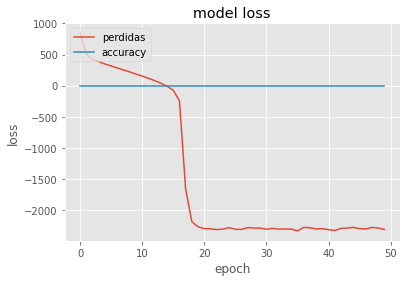

Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 1202.3824 - accuracy: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 636.5967 - accuracy: 0.0000e+00
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 556.8657 - accuracy: 0.0000e+00
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: 500.6796 - accuracy: 0.0000e+00
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: 445.8625 - accuracy: 0.0000e+00
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: 398.3170 - accuracy: 0.0000e+00
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: 358.3936 - accuracy: 0.0000e+00
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: 316.3421 - accuracy: 0.0000e+00
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: 278.2881 - accuracy: 0.0000e+00
Epoch 10/50
45/45 [==============================] - 0s 1ms/ste

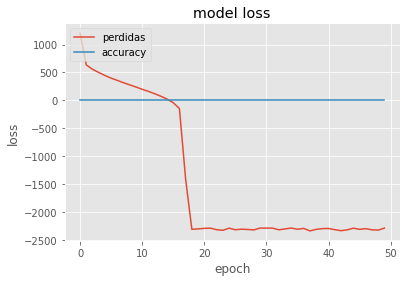

Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 426.2364 - accuracy: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 210.5052 - accuracy: 0.0000e+00
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 81.0551 - accuracy: 0.0000e+00
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: -306.5122 - accuracy: 0.0000e+00
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: -1950.2189 - accuracy: 0.0000e+00
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: -2292.9775 - accuracy: 0.0000e+00
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: -2309.7854 - accuracy: 0.0000e+00
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: -2295.4167 - accuracy: 0.0000e+00
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: -2306.8027 - accuracy: 0.0000e+00
Epoch 10/50
45/45 [==============================] - 0

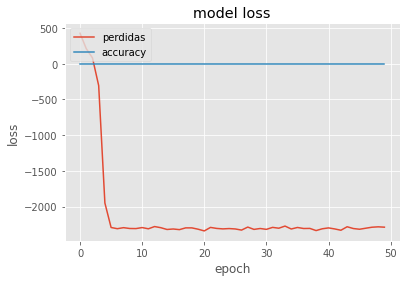

Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 393.6543 - accuracy: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 190.7253 - accuracy: 0.0000e+00
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 54.7689 - accuracy: 0.0000e+00
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: -380.1601 - accuracy: 0.0000e+00
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: -2269.2231 - accuracy: 0.0000e+00
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: -2288.0972 - accuracy: 0.0000e+00
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: -2315.4780 - accuracy: 0.0000e+00
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: -2287.6907 - accuracy: 0.0000e+00
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: -2317.3760 - accuracy: 0.0000e+00
Epoch 10/50
45/45 [==============================] - 0

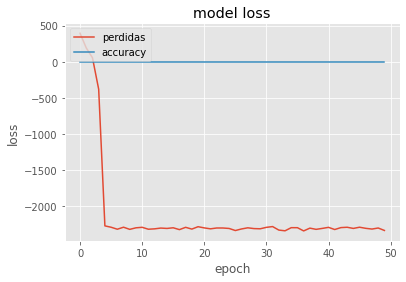

Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 384.4110 - accuracy: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 180.1960 - accuracy: 0.0000e+00
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 48.4814 - accuracy: 0.0000e+00
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: -340.4669 - accuracy: 0.0000e+00
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: -1809.9337 - accuracy: 0.0000e+00
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: -2089.5652 - accuracy: 0.0000e+00
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: -2303.3289 - accuracy: 0.0000e+00
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: -2318.4150 - accuracy: 0.0000e+00
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: -2309.5593 - accuracy: 0.0000e+00
Epoch 10/50
45/45 [==============================] - 0

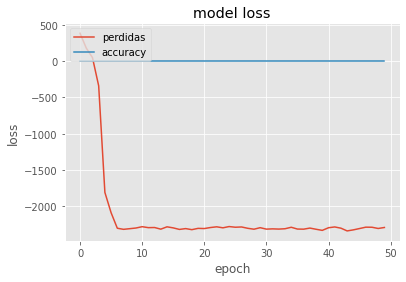

Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 504.3581 - accuracy: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 326.3931 - accuracy: 0.0000e+00
Epoch 3/50
45/45 [==============================] - 0s 2ms/step - loss: 233.5042 - accuracy: 0.0000e+00
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: 138.7284 - accuracy: 0.0000e+00
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: 25.1623 - accuracy: 0.0000e+00
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: -582.9103 - accuracy: 0.0000e+00
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: -2289.8154 - accuracy: 0.0000e+00
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: -2301.4158 - accuracy: 0.0000e+00
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: -2295.4543 - accuracy: 0.0000e+00
Epoch 10/50
45/45 [==============================] - 0s 1m

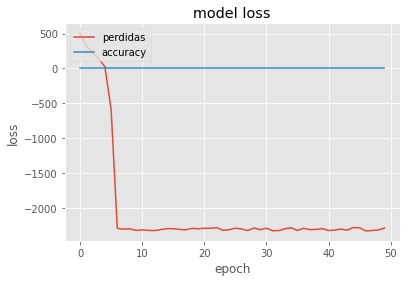

Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 501.2151 - accuracy: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 298.1126 - accuracy: 0.0000e+00
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 181.3766 - accuracy: 0.0000e+00
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: 64.2710 - accuracy: 0.0000e+00
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: -197.8560 - accuracy: 0.0000e+00
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: -2121.2610 - accuracy: 0.0000e+00
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: -2302.4653 - accuracy: 0.0000e+00
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: -2320.6292 - accuracy: 0.0000e+00
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: -2302.3298 - accuracy: 0.0000e+00
Epoch 10/50
45/45 [==============================] - 0s 

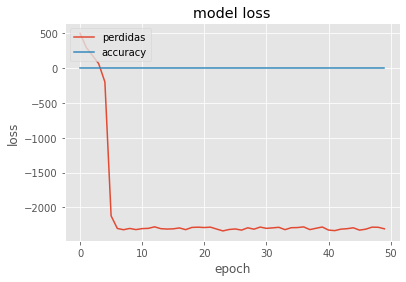

Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 301.5269 - accuracy: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 50.9077 - accuracy: 0.0000e+00
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: -1280.8140 - accuracy: 0.0000e+00
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: -2328.3555 - accuracy: 0.0000e+00
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: -2279.1509 - accuracy: 0.0000e+00
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: -2340.2834 - accuracy: 0.0000e+00
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: -2321.3064 - accuracy: 0.0000e+00
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: -2300.2969 - accuracy: 0.0000e+00
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: -2326.4575 - accuracy: 0.0000e+00
Epoch 10/50
45/45 [==============================] 

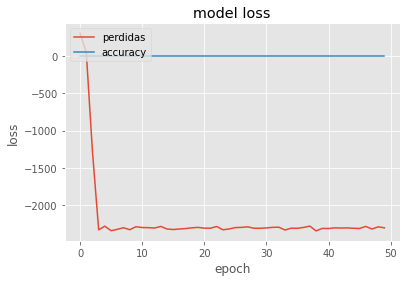

Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 543.9969 - accuracy: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 298.2095 - accuracy: 0.0000e+00
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 217.8026 - accuracy: 0.0000e+00
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 140.4371 - accuracy: 0.0000e+00
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: 58.3114 - accuracy: 0.0000e+00
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: -46.7019 - accuracy: 0.0000e+00
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: -862.7903 - accuracy: 0.0000e+00
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: -2321.5779 - accuracy: 0.0000e+00
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: -2315.2075 - accuracy: 0.0000e+00
Epoch 10/50
45/45 [==============================] - 0s 1ms/

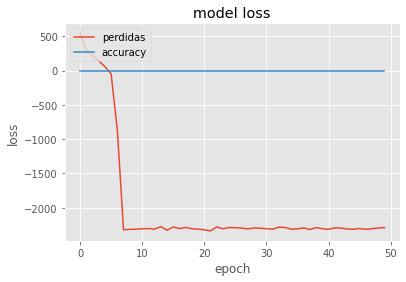

In [134]:
for capa1 in [8, 12, 20 ]:
  for capa2 in [4, 6, 8 ]:

    #definir el modelo, será secuencial dado que se pondrá un layer tras otro totalmente conectados
    model = Sequential()
    #Capa de entrada y primer capa oculta(ambos se ejecutan con esta instrucción)
    model.add(Dense(capa1, input_dim=8, activation='relu'))
    #Segunda capa oculta
    model.add(Dense(capa2, activation='relu'))
    #Capa de salida
    model.add(Dense(1, activation='relu'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X, y, epochs=50, batch_size=10)

    print(history.history.keys())
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['perdidas', 'accuracy'], loc='upper left')
    plt.show()

#Conclusiones

Para los diferentes números de neuronas en la red, la curva de pérdida se mntuvo similar. Es muy notorio que la *accuracy* de la red no mejoró en lo absuluto durante el entrenamiento, es posible que la activación ReLu no sea útil al momento de predecir valores y solo sirva para categorías.

Siendo que en este caso, con esta red en específico, la red neuronal tuvo un desempeño nulo, la regresión lineal es la de mejor desempeño para predecir el valor del parámetro "Y" 